In [1]:
import numpy as np
import synapseclient
import os
import sys
import pandas
import pylab as pl

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pylab as pl
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc

In [2]:
sys.path.append(os.environ['HOME']+"/dev/appys/lib/")
sys.path.append(os.environ['HOME']+"/dev/RA_challenge_data_analysis/leaderboard/")
import utils
import synLeaderboard
from eval_submissions_ra_challenge import *

/Users/apratap/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
syn = synapseclient.login()

Welcome, Abhishek Pratap!



In [4]:
truth_df = get_truePhenotype_testSamples_RA_challenge(syn)

####creating binary class for Precision Recall calculation 
* 1 = non responder
* 0 = responder

In [5]:
truth_df['true_class'] = np.nan
truth_df.true_class[truth_df.Response.isin(['Intermediate', 'Good'])] = 0
truth_df.true_class[truth_df.Response.isin(['Non', 'Supernon'])] = 1

In [6]:
def __get_blockWise_stats(sub_stats):
    
    #group to calculate group wise stats for each block
    grouped = sub_stats.groupby(['predict'], sort=False)
    
    #instantiate a pandas dataframe to store the results for each group (tied values)
    result = pandas.DataFrame.from_dict({'block':xrange(len(grouped)),
                                         'block_numElements'  : np.nan,
                                         'block_truePos_density' : np.nan,
                                         'block_truePos'      : np.nan,
                                         'blockValue'   : np.nan
                                         })
    
    for block,grp in enumerate(grouped):
        name,grp = grp[0],grp[1]
        truePositive = sum(grp.truth == 1)
        grp_truePositive_density = truePositive / float(len(grp))
        idxs = result.block == block
        result.block_truePos_density[idxs] = grp_truePositive_density
        result.block_numElements[idxs] = len(grp)
        result.block_truePos[idxs] = truePositive
        result.blockValue[idxs] = grp.predict.unique()
    result.block = result.block + 1
    result['cum_numElements'] = result.block_numElements.cumsum()
    result['cum_truePos'] = result.block_truePos.cumsum()
    
    return(result)

In [7]:
def get_precision_recall_fpr(y_predict, y_true):
    
    sub_stats = pandas.DataFrame.from_dict({'predict':y_predict, 'truth':y_true}, dtype='float64')
    sub_stats = sub_stats.sort_values(by=['predict'],ascending=False)

    blockWise_stats = __get_blockWise_stats(sub_stats)
    grouped = sub_stats.groupby(['predict'],sort=False)
    sub_stats = grouped.apply(__nonlinear_interpolated_evalStats,blockWise_stats)
#    sub_stats = sub_stats.sort(columns=['precision'])
    precision, recall,  fpr, threshold = sub_stats.precision.values, sub_stats.recall.values, sub_stats.fpr.values, sub_stats.predict.values 
    
    #YFG suggestion - for the case when Truth == Prediction
    # REF - https://github.com/Sage-Bionetworks/DARPA_Challenge/blob/master/challenge_config.py#L162
    #PR curve AUC (Fixes error when prediction == truth)
    #recall_new=list(recall)
    #precision_new=list(precision)
    #recall_new.reverse()
    #recall_new.append(0)
    #recall_new.reverse()
    #precision_new.reverse()
    #precision_new.append(precision_new[len(precision_new)-1])
    #precision_new.reverse()
    
    ### Implementing the change using numpy style  // Abhishek Pratap - 08/31/2016
    recall_mod = np.insert(recall,0,0)  ## adding 0 at the beginning
    precision_mod = np.insert(precision,0,precision[0]) ## adding corresponding value at the beginning 
    fpr_mod = np.insert(fpr,0,fpr[0]) ## adding corresponding value at the beginning 

    return(precision_mod, recall_mod, fpr_mod, threshold)


def __nonlinear_interpolated_evalStats(block_df, blockWise_stats):
    """
    //needs to be updated
    """
    
    blockValue = block_df.predict.unique()
    if len(blockValue) != 1:
        raise Exception("grouping by predict column doesnt yield unique predict vals per group..WIERD")
    blockValue = blockValue[0]
    blockStats = blockWise_stats[blockWise_stats.blockValue == blockValue].squeeze() #squeeze will convert one row df to series
    
    block_precision = []
    block_recall = []
    block_fpr = []
    test_FP = []
    test_TP = []
    total_elements = blockWise_stats.cum_numElements.max()
    total_truePos = blockWise_stats.cum_truePos.max()
    total_trueNeg = total_elements - total_truePos
    for block_depth,row in enumerate(block_df.iterrows()):
        block_depth += 1  #increase block depth by 1 
        #calculate the cumulative true positives seen till the last block from the current active block
        # and the total number of elements(cumulative) seen till the last block
        if blockStats.block == 1: #no previous obviously
            cum_truePos_till_lastBlock = 0
            cum_numElements_till_lastBlock = 0
            cum_trueNeg_till_lastBlock = 0
        elif blockStats.block > 1:
            last_blockStats = blockWise_stats[blockWise_stats.block == (blockStats.block-1)].squeeze()
            cum_truePos_till_lastBlock = last_blockStats['cum_truePos']
            cum_numElements_till_lastBlock = last_blockStats['cum_numElements']
            cum_trueNeg_till_lastBlock = cum_numElements_till_lastBlock - cum_truePos_till_lastBlock
            
        truePos = cum_truePos_till_lastBlock + (blockStats.block_truePos_density*block_depth)
        falsePos = cum_trueNeg_till_lastBlock + ((1 - blockStats.block_truePos_density ) * block_depth)
        test_FP.append(falsePos)
        test_TP.append(truePos)
        #precision
        interpolated_precision = truePos / float((cum_numElements_till_lastBlock+block_depth))
        block_precision.append(interpolated_precision)
        #recall == true positive rate
        interpolated_recall = truePos / float(total_truePos)
        block_recall.append(interpolated_recall)
        #fpr == false positive rate
        interpolated_fpr = falsePos / float(total_trueNeg)
        block_fpr.append(interpolated_fpr)
        
    block_df['precision'] = block_precision
    block_df['recall'] = block_recall
    block_df['fpr'] = block_fpr
    block_df['block_depth'] = np.arange(1,block_df.shape[0]+1)
    block_df['block'] = blockStats.block
    return(block_df)

In [8]:
def __temp_plot(df):
    
    fpr1, tpr1, threshold1 = roc_curve(df.true_class, df.belief_gen)
    frp1 = sorted(fpr1)
    precision1, recall1, thresholds  = precision_recall_curve(df.true_class, df.belief_gen)
    print 'linear interpolation (AUC: %0.3f)' % auc(recall1,precision1, reorder=True)

    precision2, recall2, fpr2, threshold2= get_precision_recall_fpr(df.belief_gen, df.true_class)
    print 'Non-linear interpolation (AUC: %0.3f)' % auc(recall2,precision2, reorder=True)

    plt.clf()
    fig = plt.figure(figsize=(8,6))
    fig.subplots_adjust(hspace=.5)
    ax1 = fig.add_subplot(211)
    ax1.plot(recall1, precision1, label='linear (AUC: %0.3f)' % auc(recall1,precision1, reorder=True) )
    ax1.plot(recall2, precision2, label='Non linear (AUC: %0.3f)' % auc(recall2,precision2, reorder=True) )
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_ylim([0.0, 1.2])
    ax1.set_xlim([0.0, 1.2])
    ax1.set_title('Precision-Recall')
    ax1.legend(loc="upper right",fontsize='small' )

    ax2 = fig.add_subplot(212)
    ax2.plot(fpr1,tpr1, label='linear (AUC: %0.3f)' % auc(fpr1,tpr1, reorder=True) )
    ax2.plot(fpr2, recall2, label='Non linear (AUC: %0.3f)' % auc(fpr2,recall2, reorder=True) )
    ax2.plot(np.arange(0,1.1,.1), np.arange(0,1.1,.1),'--', label='TPR=FPR')
    ax2.set_xlabel('FPR')
    ax2.set_ylabel('TPR')
    ax2.set_ylim([0.0, 1.2])
    ax2.set_xlim([0.0, 1.2])
    ax2.set_title('ROC')
    ax2.legend(loc="lower right",fontsize='small' )
    plt.show()


## Examples

### 1 : single belief score

linear interpolation (AUC: 0.613)
Non-linear interpolation (AUC: 0.225)


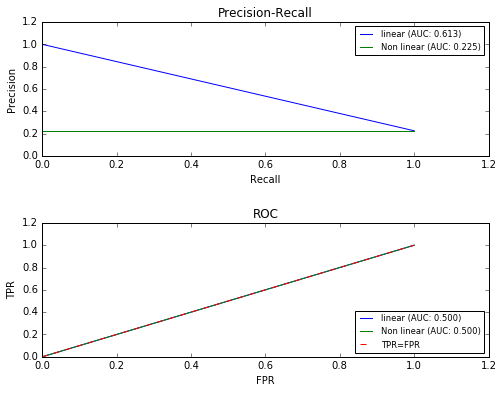

In [9]:
sub = syn.getSubmission(2363293)
df = pandas.DataFrame.from_csv(sub.filePath).reset_index()
df = df.merge(truth_df[['true_class','ID', 'Response']], left_on="ID", right_on="ID", how="outer")
__temp_plot(df)

### Example 2 : binary predictions

linear interpolation (AUC: 0.457)
Non-linear interpolation (AUC: 0.275)


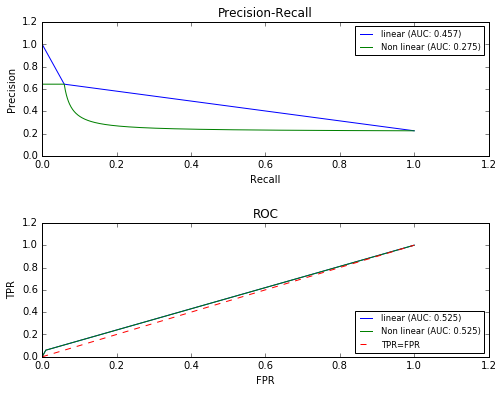

In [10]:
sub = syn.getSubmission(2363303)
df = pandas.DataFrame.from_csv(sub.filePath).reset_index()
df = df.merge(truth_df[['true_class','ID', 'Response']], left_on="ID", right_on="ID", how="outer")
__temp_plot(df)

### Example 3 : less skewed scores

linear interpolation (AUC: 0.261)
Non-linear interpolation (AUC: 0.258)


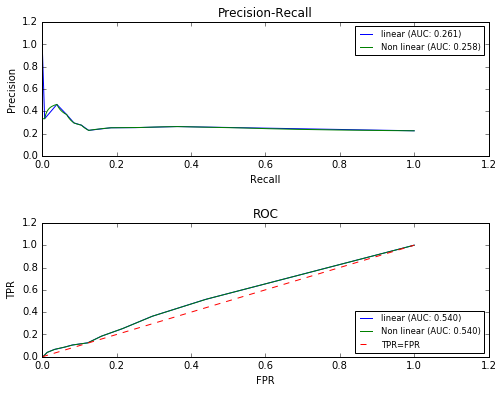

In [11]:
sub = syn.getSubmission(2364533)
df = pandas.DataFrame.from_csv(sub.filePath).reset_index()
df = df.merge(truth_df[['true_class','ID', 'Response']], left_on="ID", right_on="ID", how="outer")
#print df.belief_gen.value_counts()
__temp_plot(df)

### Example 4 : 670 uniq scores

linear interpolation (AUC: 0.381)
Non-linear interpolation (AUC: 0.381)


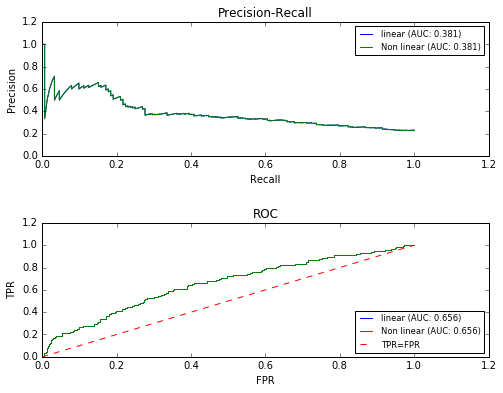

In [12]:
sub = syn.getSubmission(2368533)
df = pandas.DataFrame.from_csv(sub.filePath).reset_index()
df = df.merge(truth_df[['true_class','ID', 'Response']], left_on="ID", right_on="ID", how="outer")
__temp_plot(df)

### Testing --  When truth == prediction (May 9, 2016)

reported case by Tom  

In [13]:
y_predict = np.concatenate([np.repeat(1,25), np.repeat(0,30)])
y_true = y_predict

linear interpolation (AUC: 1.000)
Non-linear interpolation (AUC: 0.989)


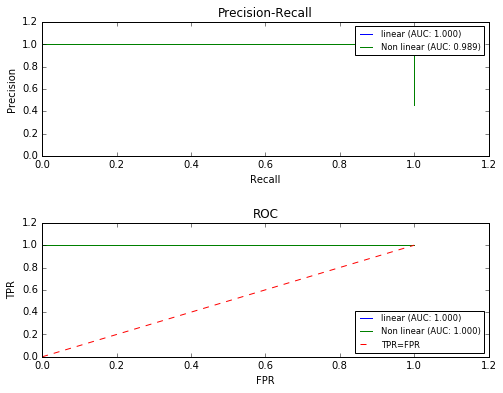

In [14]:
df = pandas.DataFrame.from_dict({'true_class':y_true, 'belief_gen':y_predict})
__temp_plot(df)

### Manually 

In [15]:
precision1, recall1, fpr1 = precision_recall_curve(y_predict, y_true)
print 'Linear interpolation (AUC: %0.3f)' % auc(recall1,precision1, reorder=True)

precision2, recall2, fpr2, threshold2 = get_precision_recall_fpr(y_predict, y_true)
print 'Non-linear interpolation (AUC: %0.3f)' % auc(recall2,precision2, reorder=True)

Linear interpolation (AUC: 1.000)
Non-linear interpolation (AUC: 0.989)


In [16]:
sub_stats = pandas.DataFrame.from_dict({'predict':y_predict, 'truth':y_true}, dtype='float64')
sub_stats = sub_stats.sort_values(by=['predict'],ascending=False)
blockWise_stats = __get_blockWise_stats(sub_stats)
grouped = sub_stats.groupby(['predict'],sort=False)

In [17]:
blockWise_stats

block  blockValue  block_numElements  block_truePos  block_truePos_density  \
0      1         1.0               25.0           25.0                    1.0   
1      2         0.0               30.0            0.0                    0.0   

   cum_numElements  cum_truePos  
0             25.0         25.0  
1             55.0         25.0

In [18]:
sub_stats = grouped.apply(__nonlinear_interpolated_evalStats,blockWise_stats)
sub_stats

predict  truth  precision  recall       fpr  block_depth  block
0       1.0    1.0   1.000000    0.04  0.000000            1    1.0
13      1.0    1.0   1.000000    0.08  0.000000            2    1.0
1       1.0    1.0   1.000000    0.12  0.000000            3    1.0
24      1.0    1.0   1.000000    0.16  0.000000            4    1.0
23      1.0    1.0   1.000000    0.20  0.000000            5    1.0
22      1.0    1.0   1.000000    0.24  0.000000            6    1.0
21      1.0    1.0   1.000000    0.28  0.000000            7    1.0
20      1.0    1.0   1.000000    0.32  0.000000            8    1.0
18      1.0    1.0   1.000000    0.36  0.000000            9    1.0
17      1.0    1.0   1.000000    0.40  0.000000           10    1.0
16      1.0    1.0   1.000000    0.44  0.000000           11    1.0
15      1.0    1.0   1.000000    0.48  0.000000           12    1.0
14      1.0    1.0   1.000000    0.52  0.000000           13    1.0
19      1.0    1.0   1.000000    0.56  0.000000           14    1.0
12      1.0    1.0   1.000000    0.60  0.000000           15    1.0
6       1.0    1.0   1.000000    0.64  0.000000           16    1.0
2       1.0    1.0   1.000000    0.68  0.000000           17    1.0
11      1.0    1.0   1.000000    0.72  0.000000           18    1.0
3       1.0    1.0   1.000000    0.76  0.000000           19    1.0
4       1.0    1.0   1.000000    0.80  0.000000           20    1.0
5       1.0    1.0   1.000000    0.84  0.000000           21    1.0
7       1.0    1.0   1.000000    0.88  0.000000           22    1.0
8       1.0    1.0   1.000000    0.92  0.000000           23    1.0
9       1.0    1.0   1.000000    0.96  0.000000           24    1.0
10      1.0    1.0   1.000000    1.00  0.000000           25    1.0
47      0.0    0.0   0.961538    1.00  0.033333            1    2.0
42      0.0    0.0   0.925926    1.00  0.066667            2    2.0
43      0.0    0.0   0.892857    1.00  0.100000            3    2.0
44      0.0    0.0   0.862069    1.00  0.133333            4    2.0
45      0.0    0.0   0.833333    1.00  0.166667            5    2.0
46      0.0    0.0   0.806452    1.00  0.200000            6    2.0
52      0.0    0.0   0.781250    1.00  0.233333            7    2.0
48      0.0    0.0   0.757576    1.00  0.266667            8    2.0
49      0.0    0.0   0.735294    1.00  0.300000            9    2.0
50      0.0    0.0   0.714286    1.00  0.333333           10    2.0
51      0.0    0.0   0.694444    1.00  0.366667           11    2.0
53      0.0    0.0   0.675676    1.00  0.400000           12    2.0
40      0.0    0.0   0.657895    1.00  0.433333           13    2.0
41      0.0    0.0   0.641026    1.00  0.466667           14    2.0
27      0.0    0.0   0.625000    1.00  0.500000           15    2.0
39      0.0    0.0   0.609756    1.00  0.533333           16    2.0
38      0.0    0.0   0.595238    1.00  0.566667           17    2.0
37      0.0    0.0   0.581395    1.00  0.600000           18    2.0
36      0.0    0.0   0.568182    1.00  0.633333           19    2.0
35      0.0    0.0   0.555556    1.00  0.666667           20    2.0
34      0.0    0.0   0.543478    1.00  0.700000           21    2.0
33      0.0    0.0   0.531915    1.00  0.733333           22    2.0
32      0.0    0.0   0.520833    1.00  0.766667           23    2.0
31      0.0    0.0   0.510204    1.00  0.800000           24    2.0
30      0.0    0.0   0.500000    1.00  0.833333           25    2.0
29      0.0    0.0   0.490196    1.00  0.866667           26    2.0
28      0.0    0.0   0.480769    1.00  0.900000           27    2.0
26      0.0    0.0   0.471698    1.00  0.933333           28    2.0
25      0.0    0.0   0.462963    1.00  0.966667           29    2.0
54      0.0    0.0   0.454545    1.00  1.000000           30    2.0